In [1]:
from MieSppForce import green_func_v2, frenel
import numpy as np

wl = 900
epsAu = frenel.get_interpolate('Au')
phi = 0
d = 2
R = 150

r0 = wl*2
h0 = 0

theta = np.linspace(-np.pi/2+0.5, np.pi/2-0.5, 50)
r = r0*np.sin(theta)
z = r0*np.cos(theta)


GEreg = np.zeros((len(z),3,3), dtype=complex)
rotGHreg = np.zeros_like(GEreg)
GHreg = np.zeros_like(GEreg)
rotGEreg = np.zeros_like(GEreg)

for i in range(len(theta)):
    GEreg[i,:,:], rotGHreg[i,:,:], GHreg[i,:,:], rotGEreg[i,:,:] = green_func_v2.getG(wl, epsAu, z[i]+h0, r[i], phi, 'sc')

/Users/semyon_b/git/SPP_ANALYTICAL/.venv/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:442: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
/Users/semyon_b/git/SPP_ANALYTICAL/.venv/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:445: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,


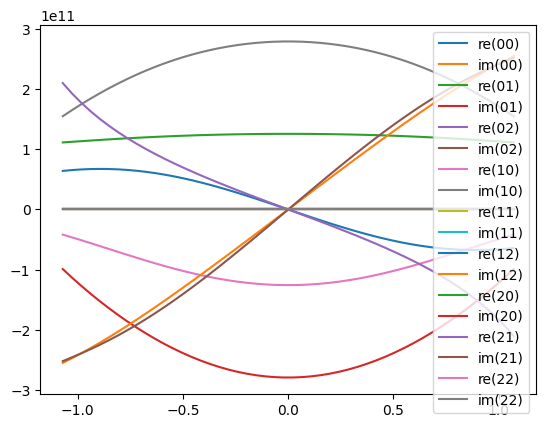

In [ ]:
import matplotlib.pyplot as plt


for i in range(3):
    for j in range(3):
        plt.plot(theta, GEreg[:,i,j].real, label=f're({i}{j})' )
        plt.plot(theta, GEreg[:,i,j].imag, label=f'im({i}{j})' )

plt.legend()


In [18]:
import numpy as np
from MieSppForce import frenel, dipoles

epsAu = frenel.get_interpolate('Au')

c_const = 299792458
eps0_const = 1 / (4 * np.pi * c_const ** 2) * 1e7
mu0_const = 4 * np.pi * 1e-7


def initial_field2(wl, alpha, amplitude, eps_interp, point, phase, a_angle):
    rp, rs = frenel.reflection_coeff_v2(wl, eps_interp, alpha)
    xnm, ynm, znm = point
    x = xnm*1e-9
    z = znm*1e-9
    k = 2*np.pi/wl/1e-9
    exp = np.exp(1j*k*np.sin(alpha)*x-1j*k*np.cos(alpha)*z)
    exp_r = np.exp(1j*k*np.sin(alpha)*x+1j*k*np.cos(alpha)*z)

    Ex_tm = amplitude * np.cos(alpha) * (exp - exp_r * rp)
    Ez_tm = amplitude * np.sin(alpha) * (exp + exp_r * rp)
    Ey_te = amplitude * exp + rs * amplitude * exp_r
    
    A = np.sin(a_angle)
    B = np.cos(a_angle)
    Phase = np.exp(1j*phase)
    E0 = np.array([[Ex_tm*B],
                   [Ey_te*A*Phase],
                   [Ez_tm*B]])
    return E0



def curl_at_point(electric_field, wl, alpha, amplitude, eps_interp,
                  point, phase, a_angle, step_nm=1):
    
    omega = 2*np.pi*c_const/wl/1e-9
    
    h_m = step_nm * 1e-9
    x0, y0, z0 = point

    # Helper: compute E-field vector at a point (returns 3×1 array)
    def E(p):
        return electric_field(wl, alpha, amplitude, eps_interp, p, phase, a_angle).flatten()

    # Shifted points for derivatives
    pxp = (x0 + step_nm, y0, z0)
    pxm = (x0 - step_nm, y0, z0)

    pyp = (x0, y0 + step_nm, z0)
    pym = (x0, y0 - step_nm, z0)

    pzp = (x0, y0, z0 + step_nm)
    pzm = (x0, y0, z0 - step_nm)


    _, Ey_pxp, Ez_pxp = E(pxp)
    _, Ey_pxm, Ez_pxm = E(pxm)

    Ex_pyp, _, Ez_pyp = E(pyp)
    Ex_pym, _, Ez_pym = E(pym)

    Ex_pzp, Ey_pzp, _ = E(pzp)
    Ex_pzm, Ey_pzm, _ = E(pzm)
    
    dEy_dx = (Ey_pxp - Ey_pxm) / (2 * h_m)
    dEz_dx = (Ez_pxp - Ez_pxm) / (2 * h_m)

    dEx_dy = (Ex_pyp - Ex_pym) / (2 * h_m)
    dEz_dy = (Ez_pyp - Ez_pym) / (2 * h_m)

    dEx_dz = (Ex_pzp - Ex_pzm) / (2 * h_m)
    dEy_dz = (Ey_pzp - Ey_pzm) / (2 * h_m)

    curl_x = dEz_dy - dEy_dz
    curl_y = dEx_dz - dEz_dx
    curl_z = dEy_dx - dEx_dy

    return np.array([curl_x, curl_y, curl_z], dtype=complex)*(-1j) / omega /mu0_const


print(dipoles.initial_field(900, np.deg2rad(25), 1, epsAu, [0,0,10], 0, np.pi/4)[1])


print(curl_at_point(initial_field2, wl=900, alpha=np.deg2rad(25), amplitude=1,
              eps_interp=epsAu, point=[0,0,10], phase=0, a_angle=np.pi/4))

[[ 3.26508816e-03+0.00051174j]
 [-3.54824013e-03-0.00067991j]
 [ 6.07628415e-05-0.00033894j]]
[ 3.26506637e-03+0.00051174j -3.54821977e-03-0.00067991j
  6.07627533e-05-0.00033894j]
